1.  Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір). 

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load and preprocess the data
file_path = "ukr.txt"
input_texts = []  # English sentences (source)
target_texts = []  # Ukrainian sentences (target)

with open(file_path, "r", encoding="utf-8") as file:
    for line in file:
        parts = line.split("\t")
        if len(parts) < 2:
            continue
        input_text = parts[0]
        target_text = parts[1]
        target_text = "\t" + target_text + "\n"
        input_texts.append(input_text)
        target_texts.append(target_text)

print(f"Loaded {len(input_texts)} sentence pairs.")

Loaded 159432 sentence pairs.


In [ ]:
input_tokenizer = Tokenizer(filters='')
target_tokenizer = Tokenizer(filters='')

input_tokenizer.fit_on_texts(input_texts)
target_tokenizer.fit_on_texts(target_texts)

input_sequences = input_tokenizer.texts_to_sequences(input_texts)
target_sequences = target_tokenizer.texts_to_sequences(target_texts)

max_encoder_seq_length = max(len(seq) for seq in input_sequences)
max_decoder_seq_length = max(len(seq) for seq in target_sequences)

input_sequences = pad_sequences(input_sequences, maxlen=max_encoder_seq_length, padding="post")
target_sequences = pad_sequences(target_sequences, maxlen=max_decoder_seq_length, padding="post")

num_encoder_tokens = len(input_tokenizer.word_index) + 1
num_decoder_tokens = len(target_tokenizer.word_index) + 1

print(f"Input vocabulary size: {num_encoder_tokens}")
print(f"Target vocabulary size: {num_decoder_tokens}")

Input vocabulary size: 18886
Target vocabulary size: 51698


Налаштування декодеру, енкодеру і моделі

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense

latent_dim = 256

encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_dim=num_encoder_tokens, output_dim=latent_dim)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=num_decoder_tokens, output_dim=latent_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 256)            4834816   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 256)            1323468   ['input_2[0][0]']             
                                                          8                                   

In [5]:
decoder_input_data = target_sequences[:, :-1]

decoder_output_data = target_sequences[:, 1:]

decoder_output_data = np.expand_dims(decoder_output_data, -1)

Тренування моделі

In [6]:
batch_size = 64
epochs = 1

model.fit(
    [input_sequences, decoder_input_data],
    decoder_output_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)

1993/1993 [==============================] - 2486s 1s/step - loss: 0.8157 - accuracy: 0.9097 - val_loss: 1.2725 - val_accuracy: 0.8398


In [15]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding_inference = Embedding(
    input_dim=num_decoder_tokens, output_dim=latent_dim
)(decoder_inputs)

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding_inference, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_tokenizer.word_index.get("\t", 0)

    stop_condition = False
    decoded_sentence = ""
    max_iterations = max_decoder_seq_length
    iterations = 0

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = target_tokenizer.index_word.get(sampled_token_index, "")

        decoded_sentence += sampled_char

        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

        iterations += 1
        if iterations >= max_iterations:
            print("Warning: Exceeded maximum iterations in decoding")
            break

    return decoded_sentence

Тест на 10 

In [17]:
for seq_index in range(10):
    input_seq = input_sequences[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

1/1 [==============================] - 0s 21ms/step
Input sentence: Go.
Decoded sentence: мені
1/1 [==============================] - 0s 21ms/step
Input sentence: Hi.
Decoded sentence: мені
1/1 [==============================] - 0s 20ms/step
Input sentence: Hi.
Decoded sentence: мені
1/1 [==============================] - 0s 21ms/step
Input sentence: Hi.
Decoded sentence: мені
1/1 [==============================] - 0s 20ms/step
Input sentence: Run!
Decoded sentence: мені
1/1 [==============================] - 0s 20ms/step
Input sentence: Run!
Decoded sentence: мені
1/1 [==============================] - 0s 21ms/step
Input sentence: Run!
Decoded sentence: мені
1/1 [==============================] - 0s 21ms/step
Input sentence: Wow!
Decoded sentence: мені
1/1 [==============================] - 0s 20ms/step
Input sentence: Wow!
Decoded sentence: мені
1/1 [==============================] - 0s 20ms/step
Input sentence: Wow!
Decoded sentence: мені


2. Проведіть експерименти з моделями бібліотеки Hugging Face (раніше - Hugging Face Transformers, https://huggingface.co/) за допомогою (наприклад) Pipeline модуля

In [18]:
from transformers import pipeline

c:\pyprojects\Laba1\khenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Приклад класифікація тексту

In [20]:
classifier = pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english")

examples = [
    "What is the capital of France?",
    "Explain the theory of relativity.",
    "Who won the last soccer world cup?"
]

for text in examples:
    result = classifier(text)
    print(f"Текст: {text}\nКатегорія: {result[0]['label']} з ймовірністю {result[0]['score']:.2f}\n")

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.
Device set to use 0


Текст: What is the capital of France?
Категорія: POSITIVE з ймовірністю 0.83

Текст: Explain the theory of relativity.
Категорія: POSITIVE з ймовірністю 1.00

Текст: Who won the last soccer world cup?
Категорія: NEGATIVE з ймовірністю 0.96



Приклад генерації тексту

In [36]:
generator = pipeline("text-generation", model="gpt2")

input_prompt = "Once upon a time, in a land far away,"
generated_text = generator(input_prompt, max_length=50, num_return_sequences=1)

print("Згенерований текст:")
print(generated_text[0]['generated_text'])

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
Device set to use 0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Згенерований текст:
Once upon a time, in a land far away, one would find that the people had not met him. He would ask for food, and they would serve him.

"I don't want to say much about this, but there was


3. Завдання щодо генерації або стилізації зображень (на вибір)

In [37]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np

# Завантаження датасету MNIST
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5

11490434/11490434 [==============================] - 2s 0us/step


In [38]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [39]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((7, 7, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"),
    ])
    return model

def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1),
    ])
    return model

In [44]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = build_generator()
discriminator = build_discriminator()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 20
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [46]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        generate_and_save_images(generator, epoch + 1, seed)
        print(f"Epoch {epoch + 1} completed.")

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")

    plt.savefig(f"image_at_epoch_{epoch:04d}.png")
    plt.show()

Запуск тренування

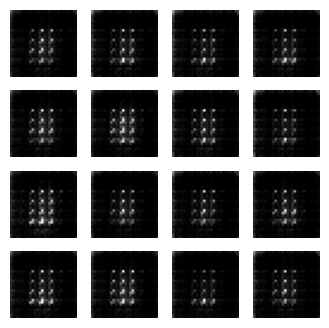

Epoch 1 completed.


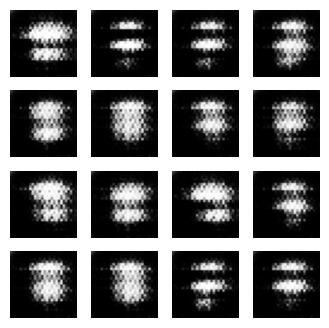

Epoch 2 completed.


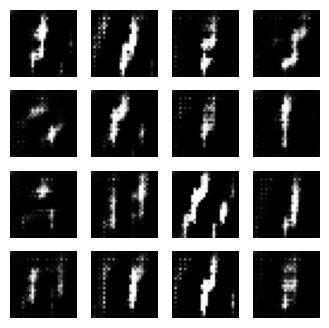

Epoch 3 completed.


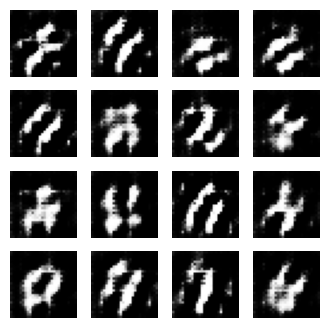

Epoch 4 completed.


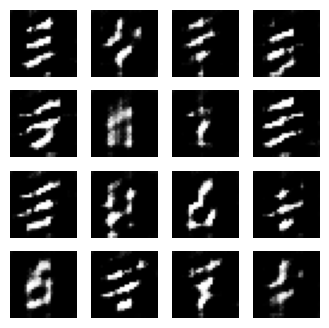

Epoch 5 completed.


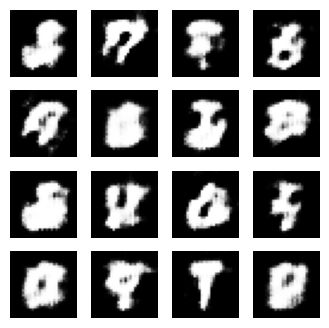

Epoch 6 completed.


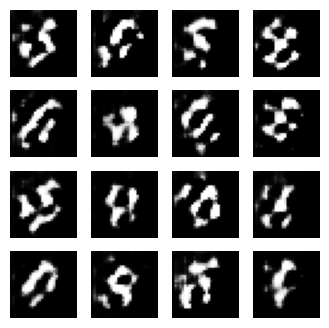

Epoch 7 completed.


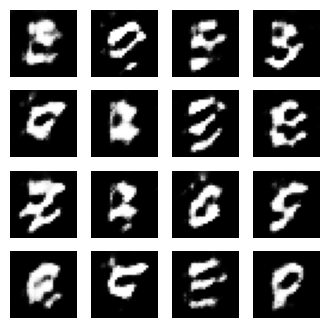

Epoch 8 completed.


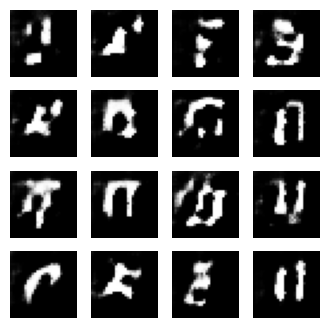

Epoch 9 completed.


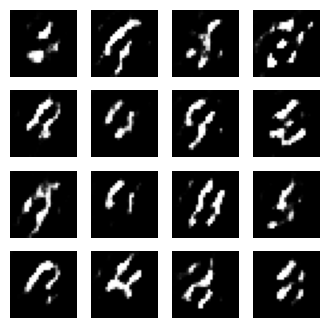

Epoch 10 completed.


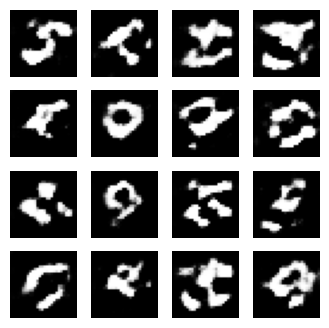

Epoch 11 completed.


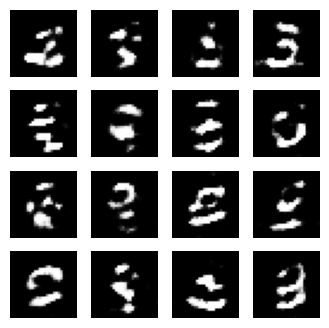

Epoch 12 completed.


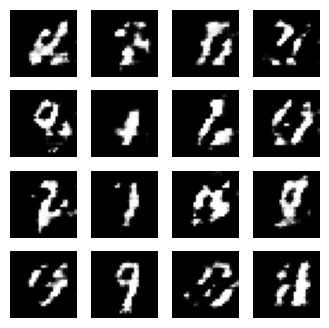

Epoch 13 completed.


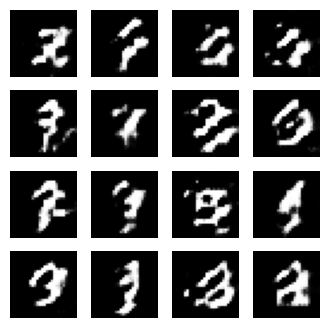

Epoch 14 completed.


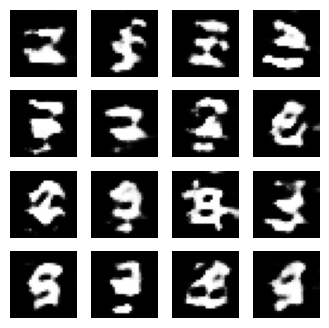

Epoch 15 completed.


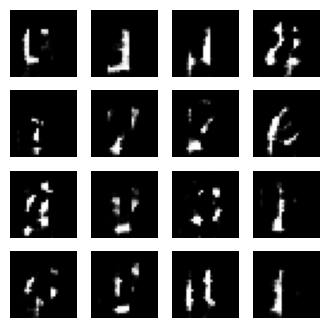

Epoch 16 completed.


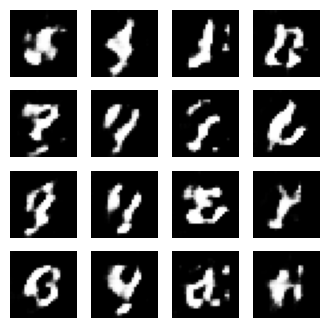

Epoch 17 completed.


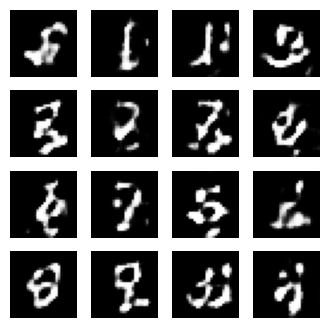

Epoch 18 completed.


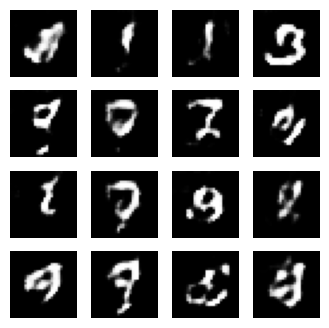

Epoch 19 completed.


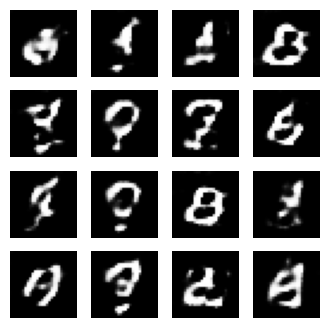

Epoch 20 completed.


In [47]:
train(train_dataset, EPOCHS)